# 03 - Predictability & Universe Filtering

1. Compute rolling predictability metrics for each ticker
2. Visualize and compare scores across universe and time
3. Select top-N most “learnable” tickers for RL agent
4. Document all decisions, assumptions, and open questions


In [1]:
# SETUP: Imports & Paths ===========================
import jupyter

import os
import pandas as pd


from tqdm import tqdm
from src.data.feature_pipeline import basic_chart_features,load_base_dataframe
from src.predictability.easiness import rolling_sharpe, rolling_r2, rolling_info_ratio, rolling_autocorr
from src.predictability.pipeline import generate_universe_easiness_report
from IPython import display


C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# LOAD OHLCV ==========================================
ohlcv_df = load_base_dataframe()
ohlcv_df.tail()

,id,symbol,timestamp,date,open,high,low,close,volume,trade_count,...,vwap_change,trade_count_change,sector_id,industry_id,return_1d,vix,vix_norm,sp500,sp500_norm,market_return_1d
429701,429702,SPY,2025-05-29 04:00:00,2025-05-29,593.06,593.2000,586.070,590.05,70073758.0,826143.0,...,-0.000250,0.128714,None,None,0.003947,0.1918,-0.006732,59.1217,0.004011,0.004011
429702,429703,SPY,2025-05-30 04:00:00,2025-05-30,588.93,591.1299,583.235,589.39,90601242.0,884337.0,...,-0.002564,0.070441,None,None,-0.001119,0.1857,-0.031804,59.1169,-0.000081,-0.000081
429703,429704,SPY,2025-06-02 04:00:00,2025-06-02,587.76,592.7900,585.060,592.71,61630502.0,728812.0,...,0.003093,-0.175866,None,None,0.005633,0.1836,-0.011309,59.3594,0.004102,0.004102
429704,429705,SPY,2025-06-03 04:00:00,2025-06-03,592.34,597.0800,591.850,596.09,63606204.0,690792.0,...,0.009093,-0.052167,None,None,0.005703,0.1769,-0.036492,59.7037,0.005800,0.005800
429705,429706,SPY,2025-06-04 04:00:00,2025-06-04,596.96,597.9500,595.490,595.93,57314199.0,629200.0,...,0.002856,-0.089161,None,None,-0.000268,0.1761,-0.004522,59.7081,0.000074,0.000074


In [3]:
# CROP THE SAMPLE =======================================
tickers = ['AAPL','GOOGL']

100%|██████████| 2/2 [00:03<00:00,  1.94s/it]


Saved all metrics to data/experiments/predictability_metrics-c8b54a75a2efb78b13975d804ec1279e7af9a68c441fd7a6114a0acc4ee4911d.csv (config hash: c8b54a75a2efb78b13975d804ec1279e7af9a68c441fd7a6114a0acc4ee4911d)


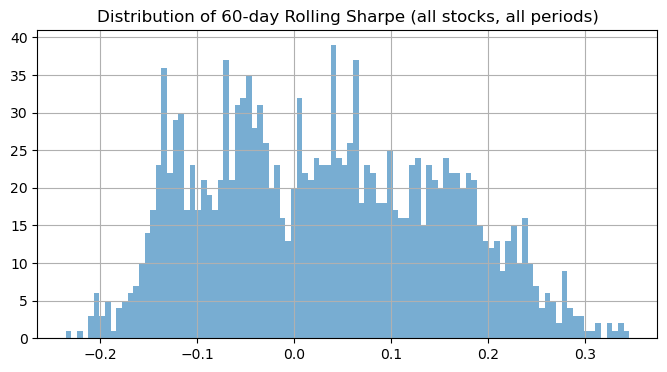

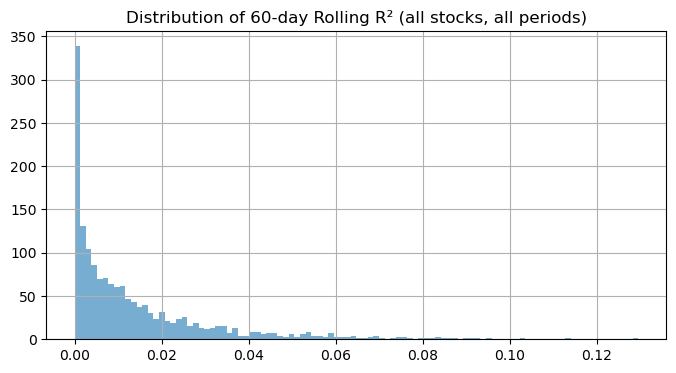

Top tickers by 60-day Sharpe in last period:


,ticker,sharpe,r2
1713,GOOGL,0.020981,0.015145
856,AAPL,-0.042672,0.011252


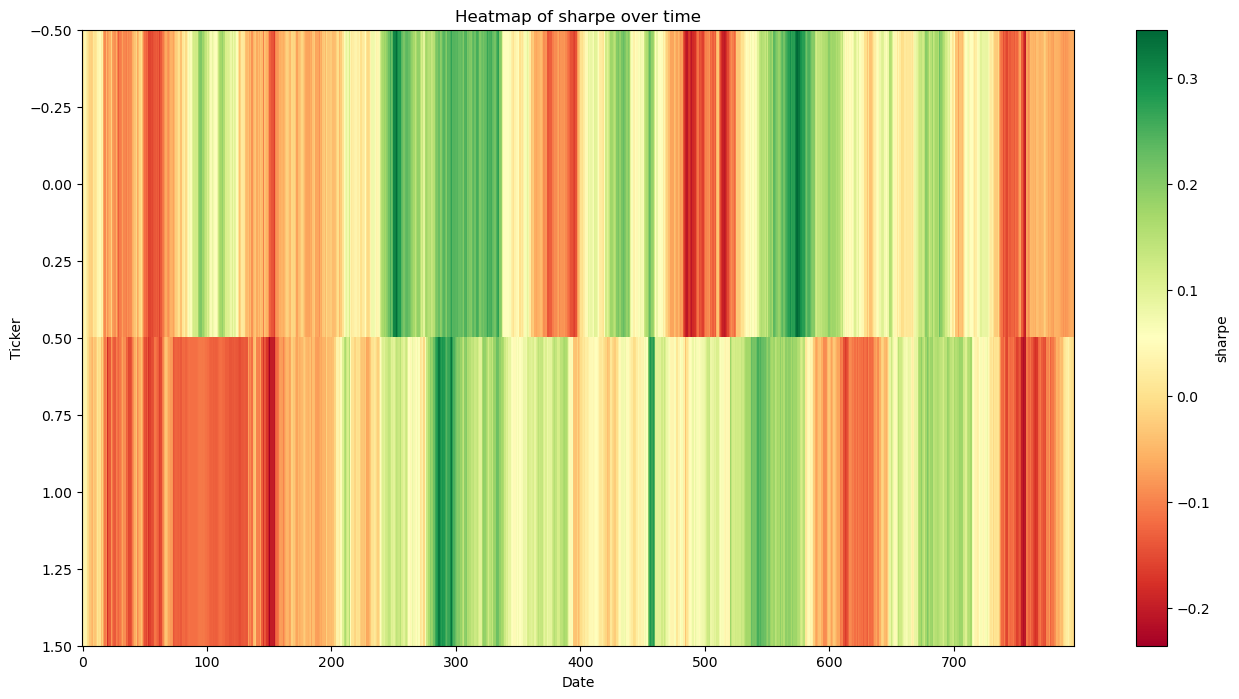

Sample of top 5 per date:


C:\Users\Francisco Sá\Dev\RL-Stock-Market-Masterpiece-Human-x-AI-Collab\src\predictability\pipeline.py:140: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sort_values('sharpe', ascending=False).head(5))


,ticker,date,return_1d,sharpe,r2,info_ratio,autocorr,config_hash,config_json
0,AAPL,2022-03-31,-0.017776,-0.015795,0.054073,0.055905,0.276086,c8b54a75a2efb78b13975d804ec1279e7af9a68c441fd7...,"{""benchmark_col"": ""market_return_1d"", ""cutoff_..."
1,GOOGL,2022-03-31,-0.020227,-0.016667,0.037105,0.034240,0.067713,c8b54a75a2efb78b13975d804ec1279e7af9a68c441fd7...,"{""benchmark_col"": ""market_return_1d"", ""cutoff_..."
2,GOOGL,2022-04-01,0.007788,0.023694,0.013065,0.074098,0.002207,c8b54a75a2efb78b13975d804ec1279e7af9a68c441fd7...,"{""benchmark_col"": ""market_return_1d"", ""cutoff_..."
3,AAPL,2022-04-01,-0.001718,0.006031,0.028246,0.059598,0.254892,c8b54a75a2efb78b13975d804ec1279e7af9a68c441fd7...,"{""benchmark_col"": ""market_return_1d"", ""cutoff_..."
4,AAPL,2022-04-04,0.023693,0.041639,0.016191,0.113741,0.238871,c8b54a75a2efb78b13975d804ec1279e7af9a68c441fd7...,"{""benchmark_col"": ""market_return_1d"", ""cutoff_..."


In [4]:

all_metric = generate_universe_easiness_report(ohlcv_df,tickers)

In [5]:
all_metric.dropna()

,ticker,date,return_1d,sharpe,r2,info_ratio,autocorr,config_hash,config_json
60,AAPL,2022-03-31,-0.017776,-0.015795,0.054073,0.055905,0.276086,c8b54a75a2efb78b13975d804ec1279e7af9a68c441fd7...,"{""benchmark_col"": ""market_return_1d"", ""cutoff_..."
61,AAPL,2022-04-01,-0.001718,0.006031,0.028246,0.059598,0.254892,c8b54a75a2efb78b13975d804ec1279e7af9a68c441fd7...,"{""benchmark_col"": ""market_return_1d"", ""cutoff_..."
62,AAPL,2022-04-04,0.023693,0.041639,0.016191,0.113741,0.238871,c8b54a75a2efb78b13975d804ec1279e7af9a68c441fd7...,"{""benchmark_col"": ""market_return_1d"", ""cutoff_..."
63,AAPL,2022-04-05,-0.018942,0.023833,0.018469,0.093778,0.235562,c8b54a75a2efb78b13975d804ec1279e7af9a68c441fd7...,"{""benchmark_col"": ""market_return_1d"", ""cutoff_..."
64,AAPL,2022-04-06,-0.018451,0.007532,0.011100,0.075544,0.209192,c8b54a75a2efb78b13975d804ec1279e7af9a68c441fd7...,"{""benchmark_col"": ""market_return_1d"", ""cutoff_..."
...,...,...,...,...,...,...,...,...,...
1709,GOOGL,2025-05-29,-0.002901,0.016215,0.014344,-0.010261,-0.125820,c8b54a75a2efb78b13975d804ec1279e7af9a68c441fd7...,"{""benchmark_col"": ""market_return_1d"", ""cutoff_..."
1710,GOOGL,2025-05-30,-0.000698,0.007872,0.020208,-0.012055,-0.133379,c8b54a75a2efb78b13975d804ec1279e7af9a68c441fd7...,"{""benchmark_col"": ""market_return_1d"", ""cutoff_..."
1711,GOOGL,2025-06-02,-0.015780,0.000193,0.023952,-0.046581,-0.132304,c8b54a75a2efb78b13975d804ec1279e7af9a68c441fd7...,"{""benchmark_col"": ""market_return_1d"", ""cutoff_..."
1712,GOOGL,2025-06-03,-0.016861,-0.016239,0.017423,-0.072034,-0.130752,c8b54a75a2efb78b13975d804ec1279e7af9a68c441fd7...,"{""benchmark_col"": ""market_return_1d"", ""cutoff_..."
